In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import numpy as np
import matplotlib.pyplot as plt
import requests
from collections import Counter

In [2]:
shakespeare_url = 'https://www.gutenberg.org/files/100/100-0.txt'
war_and_peace_url = 'https://www.gutenberg.org/files/2600/2600-0.txt'
moby_dick_url = "https://www.gutenberg.org/ebooks/2701.txt.utf-8"

def load_text(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    return response.text

shakespeare_text = load_text(shakespeare_url)
war_and_peace_text = load_text(war_and_peace_url)
moby_dick_test = load_text(moby_dick_url)

combined_text = shakespeare_text + war_and_peace_text + moby_dick_test

all_chars = sorted(set(combined_text))
vocab_size = len(all_chars)

char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for i, char in enumerate(all_chars)}

print(f"Total unique characters (vocabulary size): {vocab_size}")

test_sequence = combined_text[:32]
print(f"Original sequence: {test_sequence}")

Total unique characters (vocabulary size): 130
Original sequence: *** START OF THE PROJECT GUTENBE


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CharSeqRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharSeqRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

input_size = output_size = vocab_size
hidden_size = 128
learning_rate = 1e-3

model = CharSeqRNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
sequence_length = 32

def get_batch(text, batch_size):
    x = []
    y = []
    for _ in range(batch_size):
        start_index = np.random.randint(0, len(text) - sequence_length - 1)
        sequence = text[start_index:start_index + sequence_length]
        target = text[start_index + 1:start_index + sequence_length + 1]

        x.append([char_to_int[char] for char in sequence])
        y.append([char_to_int[char] for char in target])

    x = torch.tensor(x, dtype=torch.long).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)
    return x, y

In [5]:
num_epochs = 50
batch_size = 64
num_batches = 3000

train_losses = []
val_losses = []

train_errors = []
val_errors = []

for epoch in range(num_epochs):
    hidden = model.init_hidden(batch_size)
    for i in range(num_batches):
        model.train()
        optimizer.zero_grad()

        x, y = get_batch(combined_text, batch_size)

        x_one_hot = nn.functional.one_hot(x, num_classes=vocab_size).float()
        outputs, hidden = model(x_one_hot, hidden.detach())
        loss = criterion(outputs.transpose(1, 2), y)

        _, predictions = torch.max(outputs, dim=2)
        train_error = (predictions != y).float().mean().item()
        train_errors.append(train_error)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_losses.append(loss.item())

        if (i + 1) % 1000 == 0:
            model.eval()
            val_loss = 0
            val_error = 0
            with torch.no_grad():
                for j in range(int(.25 * num_batches)):
                  val_x, val_y = get_batch(combined_text, batch_size)
                  val_x_one_hot = nn.functional.one_hot(val_x, num_classes=vocab_size).float()
                  val_outputs, _ = model(val_x_one_hot, hidden)

                  val_loss += criterion(val_outputs.transpose(1, 2), val_y)

                  _, val_pred = torch.max(val_outputs, dim=2)
                  val_error += (val_pred != val_y).float().mean().item()

            val_losses.append(val_loss.item() / int(.25 * num_batches))
            val_errors.append(val_error / int(.25 * num_batches))
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{num_batches}], '
                  f'Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, '
                  f'Train Error: {train_error:.4f}, Val Error: {val_error:.4f}')

Epoch [1/50], Batch [1000/3000], Train Loss: 2.1376, Val Loss: 1623.7430, Train Error: 0.6108, Val Error: 463.4858
Epoch [1/50], Batch [2000/3000], Train Loss: 2.0367, Val Loss: 1507.9166, Train Error: 0.5835, Val Error: 435.5693
Epoch [1/50], Batch [3000/3000], Train Loss: 1.8991, Val Loss: 1453.4534, Train Error: 0.5571, Val Error: 419.6890
Epoch [2/50], Batch [1000/3000], Train Loss: 1.8940, Val Loss: 1421.9066, Train Error: 0.5557, Val Error: 411.4814
Epoch [2/50], Batch [2000/3000], Train Loss: 1.9296, Val Loss: 1397.7563, Train Error: 0.5664, Val Error: 406.0234
Epoch [2/50], Batch [3000/3000], Train Loss: 1.8491, Val Loss: 1379.6165, Train Error: 0.5356, Val Error: 400.3999
Epoch [3/50], Batch [1000/3000], Train Loss: 1.8241, Val Loss: 1368.9740, Train Error: 0.5342, Val Error: 397.6519
Epoch [3/50], Batch [2000/3000], Train Loss: 1.7777, Val Loss: 1357.3298, Train Error: 0.5308, Val Error: 395.5571
Epoch [3/50], Batch [3000/3000], Train Loss: 1.8242, Val Loss: 1348.0712, Train 

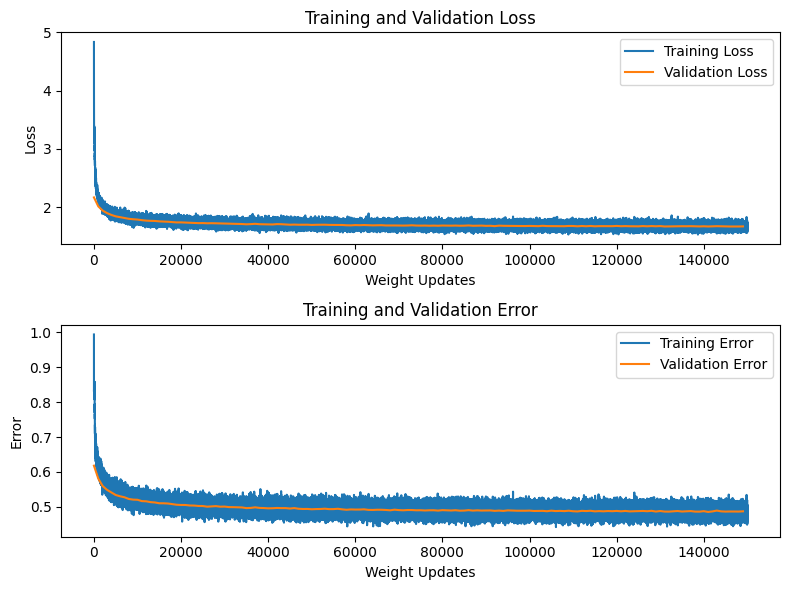

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(train_losses, label="Training Loss")
ax1.plot(range(0, len(train_losses), 1000), val_losses, label="Validation Loss")
ax1.set_xlabel("Weight Updates")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Training and Validation Loss")

ax2.plot(train_errors, label="Training Error")
ax2.plot(range(0, len(train_errors), 1000), val_errors, label="Validation Error")
ax2.set_xlabel("Weight Updates")
ax2.set_ylabel("Error")
ax2.legend()
ax2.set_title("Training and Validation Error")

plt.tight_layout()
plt.show()

In [7]:
def generate_text(model, start_text, length=100):
    model.eval()
    chars = [char_to_int[char] for char in start_text]
    hidden = model.init_hidden(1) # batch size 1

    for i in range(length):
        x = torch.tensor([chars[-1]], dtype=torch.long).view(1, 1).to(device)
        x_one_hot = nn.functional.one_hot(x, num_classes=vocab_size).float()
        output, hidden = model(x_one_hot, hidden)


        prob = nn.functional.softmax(output[0, -1], dim=0).detach().cpu().numpy()
        next_char_idx = np.random.choice(len(prob), p=prob)
        chars.append(next_char_idx)


    generated_text = ''.join(int_to_char[idx] for idx in chars)
    return generated_text

for i in range(4):
    print(f"GENERATED SENTENCE NUMBER {i+1}:")
    start_text = "Th"
    generated_text = generate_text(model, start_text, length=100)
    print(generated_text)
    print("\n")

GENERATED SENTENCE NUMBER 1:
Thy mean, know you.

INGo, new a perceise like away,
was but not they perceive term
Anaton to bleb


GENERATED SENTENCE NUMBER 2:
The cast it standfuncross countion as are yar it weres his devilits—

COUNT.
For ye indrgeivigness,


GENERATED SENTENCE NUMBER 3:
Thabiness of
King and strange wire when the brother quickle what be.

SUFFODERIBIN.
Cassings part 


GENERATED SENTENCE NUMBER 4:
The drumg the clason made othing not, these drcaped, force for his
were. And yed is that mother and w


